# 13.8 区域卷积神经网络（R-CNN）系列
- **目录**
  - 13.8.1 R-CNN
  - 13.8.2 Fast R-CNN
  - 13.8.3 Faster R-CNN
  - 13.8.4 Mask R-CNN

- 除了 13.7节中描述的单发多框检测之外， **区域卷积神经网络（region-based CNN或regions with CNN features，R-CNN）** 也是将深度模型应用于目标检测的开创性工作之一。 
- 本节将简单介绍R-CNN及其一系列改进方法的原理：
  - 快速的R-CNN（Fast R-CNN）
  - 更快的R-CNN（Faster R-CNN）
  - 掩码R-CNN（Mask R-CNN） 

## 13.8.1 R-CNN
- **R-CNN**首先从输入图像中选取若干（例如2000个）**提议区域**（如锚框也是一种选取方法），并标注它们的类别和边界框（如偏移量）。
- 然后，用卷积神经网络对**每个提议区域**进行前向传播以抽取其特征。
- 接下来，我们用每个提议区域的特征来预测类别和边界框。
<center><img src='../img/r-cnn.svg'></center>
<center>图13.8.1 R-CNN模型</center>
- 具体来说，R-CNN包括以下四个步骤：
  - （1）对输入图像使用**选择性搜索**来选取多个高质量的提议区域（注：被认为有很高概率包含某种对象的图像区域）。这些提议区域通常是在多个尺度下选取的，并具有不同的形状和大小。每个提议区域都将被标注类别和真实边界框。
  - （2）选择一个**预训练**的卷积神经网络（注：通常是一个已经在大型数据集例如 ImageNet上训练过的网络。），并将其在输出层之前**截断**（注：不使用整个网络，只使用到某一层，通常是全连接层之前的卷积层，以获得区域特征）。将每个提议区域变形为网络需要的输入尺寸（注：CNN需要固定尺寸的输入，每个提议区域都会被缩放或裁剪到该固定尺寸），并通过前向传播输出抽取的提议区域特征。
  - （3）将每个提议区域的**特征连同其标注的类别作为一个样本**。训练多个**支持向量机**对目标分类（每个类别都有一个SVM），其中每个支持向量机用来判断样本是否属于某一个类别。
  - （4）将每个提议区域的特征连同其标注的边界框作为一个样本，训练**线性回归模型**来预测真实边界框。
- 尽管R-CNN模型通过预训练的卷积神经网络有效地抽取了图像特征，但它的速度很慢。
  - 想象一下，我们可能从一张图像中选出上千个提议区域，这需要上千次的卷积神经网络的前向传播来执行目标检测。
  - 这种庞大的计算量使得R-CNN在现实世界中难以被广泛应用。

----------
- **说明：何为选择性搜索？**
  - 选择性搜索（Selective Search）是一种用于对象检测的区域提议算法。
    - 它的主要目的是在图像中找出可能含有对象的区域，以便后续进行更精细的分析，这些区域被称为“提议区域”（Proposal Regions或Region Proposals）。
    - 提议区域是指从图像中提取的潜在包含目标的候选区域。它们是目标检测算法的核心步骤之一，旨在减少计算量，避免对整张图像的每个像素进行密集检测
  - **工作原理**
    - **初始分割**：图像首先被分割成小的，相互重叠的区域。这通常是通过一种简单的图像分割算法完成的，如**分水岭算法**。
    - **合并策略**：然后，算法逐渐合并这些初始小区域以形成更大的区域。在每一步，选择性搜索算法会基于某种相似性准则（如颜色、纹理、大小或形状兼容性）来合并最相似的区域。
    - **多尺度搜索**：合并操作在多个尺度和不同的参数设置下进行，以捕获不同大小和纵横比的对象。
    - **生成提议**：在整个合并过程中，每次合并生成的新区域都作为一个可能包含对象的提议区域。
  - 为什么需要选择性搜索？
    - 在对象检测任务中，一个简单的方法是遍历图像的所有可能区域并检查每一个是否包含对象，但是其计算成本非常高。
    - 选择性搜索通过从图像中**快速并准确**地提取出**可能包含对象的区域**，大大减少了需要进一步分析的区域数量。
  - 在R-CNN中的应用：在R-CNN（Regions with CNN features）模型中，选择性搜索用于生成提议区域，这些区域然后被送入一个预训练的卷积神经网络（CNN）以提取特征。后续步骤（如分类和边界框回归）则在这些特征上进行。
  - 选择性搜索提供了一种高效的方式来减少对象检测任务的复杂性，尽管它可能会牺牲一些准确性。
    - 这是因为选择性搜索可能会遗漏一些较难检测的对象，或者可能会生成过多的无效提议。
    - 但在实践中，它通常能提供足够好的性能和效率的平衡。
-----------

## 13.8.2 Fast R-CNN

- R-CNN的主要性能瓶颈在于，对每个**提议区域**，卷积神经网络的前向传播是**独立的**，而没有共享计算。
- 由于这些区域通常有重叠，独立的特征抽取会导致重复的计算。
- **Fast R-CNN**对R-CNN的主要改进之一，是**仅在整张图象上执行卷积神经网络的前向传播**。
<center><img src='../img/fast-rcnn.svg'></center>
<center>图13.8.2 Fast R-CNN模型</center>
- 图13.8.2描述了Fast R-CNN模型，主要计算如下：
  - 与R-CNN相比，Fast R-CNN用来提取特征的卷积神经网络的输入是**整个图像**，而不是各个提议区域。
    - 此外，这个网络通常会参与训练。
    - 设输入为一张图像，将卷积神经网络的输出的形状记为$1 \times c \times h_1  \times w_1$。
  - 假设选择性搜索生成了$n$个提议区域。这些形状各异的提议区域在卷积神经网络的**输出上**分别标出了形状各异的**兴趣区域**。
    - 然后，这些感兴趣的区域需要进一步抽取出形状相同的特征（比如指定高度$h_2$和宽度$w_2$），以便于连结后输出。
    - 为了实现这一目标，Fast R-CNN引入了**兴趣区域池化层（RoI pooling）**：将卷积神经网络的输出和提议区域作为输入，输出连结后的各个提议区域抽取的特征，形状为$n \times c \times h_2 \times w_2$。
  - 通过全连接层将输出形状变换为$n \times d$，其中**超参数$d$取决于模型设计**。
  - 预测$n$个提议区域中每个区域的类别和边界框。
    - 更具体地说，在预测类别和边界框时，将全连接层的输出分别转换为形状为$n \times q$（$q$是类别的数量）的输出和形状为$n \times 4$的输出。
    - 其中预测类别时使用softmax回归。
- 在Fast R-CNN中提出的兴趣区域池化层与 6.5节中介绍的池化层有所不同。
  - 在池化层中，我们通过设置池化窗口、填充和步幅的大小来间接控制输出形状。
  - 而**兴趣区域池化层对每个区域的输出形状是可以直接指定的**。
- 例如，指定每个区域输出的高和宽分别为$h_2$和$w_2$。
  - 对于任何形状为$h \times w$的兴趣区域窗口，该窗口将被划分为$h_2 \times w_2$子窗口网格，其中每个子窗口的大小约为$(h/h_2) \times (w/w_2)$。
  - 在实践中，任何子窗口的高度和宽度都应向上取整，其中的最大元素作为该子窗口的输出。
- 因此，兴趣区域池化层可从形状各异的兴趣区域中均抽取出形状相同的特征。
- 作为说明性示例， 图13.8.3中提到，在$4 \times 4$的输入中，选取了左上角$3\times 3$的兴趣区域。
  - 对于该兴趣区域，我们通过$2\times 2$的兴趣区域池化层得到一个$2\times 2$的输出。
  - 请注意，四个划分后的子窗口中分别含有元素0、1、4、5（5最大）；2、6（6最大）；8、9（9最大）；以及10。
<center><img src='../img/roi.svg'></center>
<center>图13.8.3 一个$2\times2$  的兴趣区域池化层</center>

- **要点：**
  - **共享计算**：与 R-CNN 相比，Fast R-CNN 在整张图像上执行卷积神经网络的前向传播，而不是在每个提议区域上独立执行，从而避免了重复计算。
  - **特征抽取**：Fast R-CNN 使用的卷积神经网络不仅针对整个图像，而且通常参与训练。设输入图像，卷积神经网络的输出形状为 $1 \times c \times h_1  \times w_1$。
  - **兴趣区域池化层（RoI 池化层）**：
    - 从形状各异的兴趣区域中抽取出形状相同的特征。
    - 指定每个区域输出的高和宽分别为 $h_2$ 和 $w_2$。
    - 将每个兴趣区域窗口划分为 $h_2 \times w_2$ 子窗口网格，并向上取整每个子窗口的大小。
    - 子窗口中的最大元素作为该子窗口的输出。
  - **全连接层**：通过全连接层将池化层的输出形状变换为 $n \times d$，其中 $d$ 为超参数。
  - **预测类别和边界框**：
    - 预测 $n$ 个提议区域的类别和边界框。
    - 类别预测形状为 $n \times q$（$q$ 是类别数量），边界框预测形状为 $n \times 4$。
    - 使用 softmax 回归进行类别预测。
  - **池化层与兴趣区域池化层的区别**：池化层通过设置窗口、填充和步幅的大小来间接控制输出形状，而兴趣区域池化层可以直接指定每个区域的输出形状。
  - **效率提升**：通过在整张图像上共享计算，Fast R-CNN 比 R-CNN 更高效，避免了因区域重叠导致的计算浪费。

-------------
- **说明：RoI pooling的Pytorch实现不一致问题**
  - RoI池化的详细内容可参考[《图解 RoIPooling、RoIAlign 和 RoIWarp》。](https://zhuanlan.zhihu.com/p/273587749)
  - 下面Pytorch的roi_pool函数的实现与RoI池化原理并不完全一致，有人提出过[该疑问](https://discuss.pytorch.org/t/understanding-roi-pool-of-fast-r-cnn/159617/1)，但是没人回答，估计也是一笔糊涂账。
  - 也有人认为是历史遗留问题(a historical issue)，可参考[此网文。](https://github.com/open-mmlab/mmdetection/issues/835)
-----------

- 下面，我们演示了兴趣区域池化层的计算方法。
  - 假设卷积神经网络抽取的特征`X`的高度和宽度都是4，且只有单通道。

In [1]:
%matplotlib inline
import torch
import torchvision

X = torch.arange(16.).reshape(1, 1, 4, 4)
## 交换X中元素5和6的位置，看看RoI池化的结果有何效果
X[0,0,1,1] = 6
X[0,0,1,2] = 5
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  6.,  5.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

- 让我们进一步假设输入图像的高度和宽度都是40像素，且选择性搜索在此图像上生成了两个提议区域。
- 每个区域由5个元素表示：区域目标类别、左上角和右下角的$(x, y)$坐标。


In [3]:
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

- 由于`X`的高和宽是输入图像高和宽的$1/10$，因此，两个提议区域的坐标先按`spatial_scale`乘以0.1。
- 然后，在`X`上分别标出这两个兴趣区域`X[:, :, 0:3, 0:3]`和`X[:, :, 1:4, 0:4]`。
- 最后，在$2\times 2$的兴趣区域池化层中，每个兴趣区域被划分为子窗口网格，并进一步抽取相同形状$2\times 2$的特征。


In [4]:
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)

tensor([[[[ 6.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

## 13.8.3 Faster R-CNN

- 为了较精确地检测目标结果，Fast R-CNN模型通常需要在选择性搜索中生成大量的提议区域。
- **Faster R-CNN**提出将选择性搜索替换为**区域提议网络（region proposal network）**，从而**减少提议区域的生成数量**，并保证目标检测的精度。
<center><img src='../img/faster-rcnn.svg'></center>
<center>图13.8.4 Faster R-CNN 模型</center>

- 与Fast R-CNN相比，Faster R-CNN只将生成提议区域的方法**从选择性搜索改为了区域提议网络**，模型的其余部分保持不变。具体来说，区域提议网络的计算步骤如下：
  - （1）使用填充为1的$3\times 3$的卷积层变换卷积神经网络的输出，并将输出通道数记为$c$。这样，卷积神经网络为图像抽取的特征图中的每个单元均得到一个长度为$c$的新特征。
  - （2）以特征图的每个像素为中心，生成多个不同大小和宽高比的锚框并标注它们。
  - （3）使用锚框中心单元长度为$c$的特征，分别预测该锚框的二元类别（含目标还是背景）和边界框。
  - （4）使用非极大值抑制，从预测类别为目标的预测边界框中移除相似的结果。最终输出的预测边界框即是兴趣区域池化层所需的提议区域。
- 值得一提的是，区域提议网络作为Faster R-CNN模型的一部分，是和整个模型一起训练得到的。
  - 换句话说，Faster R-CNN的目标函数不仅包括目标检测中的类别和边界框预测，还包括区域提议网络中锚框的二元类别和边界框预测。
- 作为端到端训练的结果，区域提议网络能够学习到如何生成高质量的提议区域，从而在减少了从数据中学习的提议区域的数量的情况下，仍保持目标检测的精度。

## 13.8.4 Mask R-CNN

- 如果在训练集中还标注了每个目标在图像上的**像素级位置**，那么**Mask R-CNN**能够有效地利用这些详尽的标注信息进一步提升目标检测的精度。
<center><img src='../img/mask-rcnn.svg'></center>
<center>图13.8.5 Mask R-CNN 模型</center>
- 如图13.8.5所示，Mask R-CNN是基于Faster R-CNN修改而来的。
- 具体来说，Mask R-CNN将兴趣区域池化层替换为了**兴趣区域对齐层**，使用 **双线性插值（bilinear interpolation）** 来保留特征图上的空间信息，从而更适于像素级预测。
- 兴趣区域对齐层的输出包含了所有与兴趣区域的形状相同的特征图。
- 它们不仅被用于预测每个兴趣区域的类别和边界框，还通过额外的全卷积网络预测目标的**像素级位置**。
- 何恺明团队关于Mask R-CNN的经典文献在[此处](http://arxiv.org/pdf/1703.06870)，可深入研究。
- 本章的后续章节将更详细地介绍如何使用全卷积网络预测图像中**像素级的语义**。

## 小结

* R-CNN对图像选取若干提议区域，使用卷积神经网络对每个提议区域执行前向传播以抽取其特征，然后再用这些特征来预测提议区域的类别和边界框。
* Fast R-CNN对R-CNN的一个主要改进：只对整个图像做卷积神经网络的前向传播。它还引入了兴趣区域池化层，从而为具有不同形状的兴趣区域抽取相同形状的特征。
* Faster R-CNN将Fast R-CNN中使用的选择性搜索替换为参与训练的区域提议网络，这样后者可以在减少提议区域数量的情况下仍保证目标检测的精度。
* Mask R-CNN在Faster R-CNN的基础上引入了一个全卷积网络，从而借助目标的像素级位置进一步提升目标检测的精度。

--------------
- **附录：Mask R-CNN应用**

- **（1）从头开始训练Mask R-CNN模型**

In [1]:
import os
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F
import torchvision.transforms as T
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt

In [ ]:
# 1. 自定义数据集类
class CocoDataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        #self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [img_id for img_id in list(sorted(self.coco.imgs.keys()))
                    if len(self.coco.getAnnIds(imgIds=img_id)) > 0]

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        
        num_objs = len(coco_annotation)
        
        boxes = []
        masks = []
        labels = []
        
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
            masks.append(coco.annToMask(coco_annotation[i]))
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        #print('boxes--------------',boxes)
        image_id = torch.tensor([img_id])
        if len(boxes) > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.zeros((0,), dtype=torch.float32)  # 空张量

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [ ]:
# 2. 模型定义
def get_model_instance_segmentation(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)
    return model

In [ ]:
# 3. 训练函数
def train(model, data_loader, optimizer, device, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
        print(f'Epoch {epoch}: Loss - {losses.item()}')

In [ ]:
# 4. 预测函数
def predict(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    transform = torchvision.transforms.ToTensor()
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(img_tensor)
    
    return img, prediction[0]

In [ ]:
# 5. 可视化预测结果
def visualize_prediction(image, prediction, threshold=0.5):
    img_array = np.array(image)
    masks = prediction['masks'].cpu().numpy()
    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    for i in range(len(scores)):
        if scores[i] > threshold:
            mask = masks[i, 0]
            box = boxes[i]
            
            # 绘制边界框
            cv2.rectangle(img_array, 
                         (int(box[0]), int(box[1])), 
                         (int(box[2]), int(box[3])),
                         (0, 255, 0), 2)
            
            # 绘制mask
            colored_mask = np.zeros_like(img_array)
            colored_mask[mask > 0.5] = [0, 0, 255]
            img_array = cv2.addWeighted(img_array, 1, colored_mask, 0.5, 0)
    
    return Image.fromarray(img_array)

In [ ]:
# 主程序
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# 数据集路径
data_root = "../data/coco/train2017"
ann_file = "../data/coco/annotations/instances_train2017.json"

# 创建数据集和数据加载器
dataset = CocoDataset(data_root, ann_file, transforms=torchvision.transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# 创建模型
num_classes = 91  # COCO数据集的类别数（包括背景）
model = get_model_instance_segmentation(num_classes)
model.to(device)

# 设置优化器
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# 训练模型
train(model, data_loader, optimizer, device, num_epochs=10)

# 保存模型
torch.save(model.state_dict(), 'mask_rcnn_model.pth')

In [ ]:
# 预测示例
test_image_path = "..img/streetview1.jpg"
image, prediction = predict(model, test_image_path, device)

# 可视化结果
result_image = visualize_prediction(image, prediction)
result_image.save('prediction_result.jpg')

- **（2）使用Mask R-CNN预训练模型进行目标检测和图像分割**

In [3]:
# 加载预训练的 Mask R-CNN 模型（基于 ResNet-50 和 FPN）
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# 将模型移动到 GPU（如果可用）
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# 打印模型结构
#model

F:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\hp/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [01:33<00:00, 1.90MB/s]


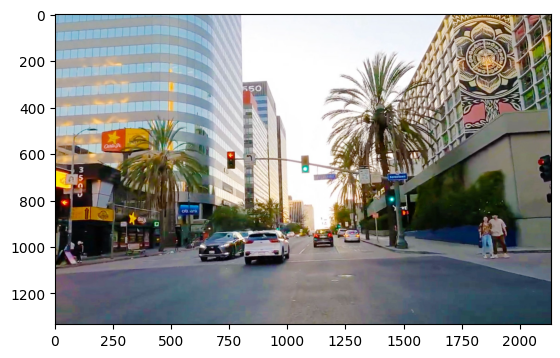

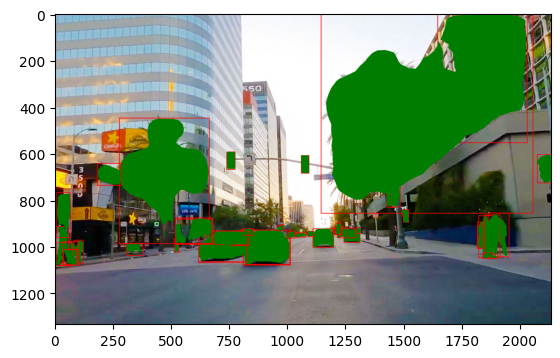

In [4]:
# 加载图像
image_path = "../img/streetview1.jpg"
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.show()
# 图像预处理
transform = T.Compose([
    T.ToTensor(),  # 将图像转换为 Tensor
])
image_tensor = transform(image).unsqueeze(0).to(device)

# 设置模型为评估模式
model.eval()

# 推理
with torch.no_grad():
    prediction = model(image_tensor)

# 可视化结果
def visualize_prediction(image, prediction):
    image = image.copy()
    for box, mask, label in zip(prediction[0]['boxes'], prediction[0]['masks'], prediction[0]['labels']):
        box = box.cpu().numpy().astype(int)
        mask = mask.cpu().numpy().squeeze()

        # 绘制边界框
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

        # 绘制掩码
        mask = (mask > 0.5).astype(np.uint8)
        image[mask == 1] = [0, 125, 0]

    plt.imshow(image)
    plt.show()

visualize_prediction(np.array(image), prediction)

-----------